# **Problem Statement [[src]](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=True.csv)**

This dataset contains articles about US elections, basically articles are divided into classes "Fake" and "Real" based on its content.

1: Fake<br>
0: Real

## **Task:** 

Develop an ML model which can classify whether the article is "Real" or "Fake"

Steps Involved:

1. Reading Data
2. Text Pre-processing
3. Stemming or Lemmatization
4. Encoding sentences
5. Word Embedding (Word2Vec or Glove) 
6. Building LSTM model
7. Training the model
8. Testing and evaluation

# **1. Importing packages and loading dataset**

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Kaggle_Fake_News_Classifier(LSTM)/dataset/test.csv.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/Kaggle_Fake_News_Classifier(LSTM)/dataset/train.csv.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/Kaggle_Fake_News_Classifier(LSTM)/dataset/test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  /content/drive/MyDrive/Colab Notebooks/Kaggle_Fake_News_Classifier(LSTM)/dataset/train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [50]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models import KeyedVectors

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense


warnings.simplefilter(action='ignore')
plt.style.use('seaborn')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
train = pd.read_csv('train.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [52]:
test = pd.read_csv('test.csv')
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [53]:
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (20800, 5)
Test Shape (5200, 4)


In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [55]:
print('Title : ',train.iloc[1,1])
print('Content : \n',train.iloc[1,2])

Title :  FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart
Content : 
 Daniel J. Flynn


# **2. Data Pre-processing**

## **2.1. Dealing with missing values**

In [56]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [57]:
# Dropping 'author' column in train and test set

del train['author']
del test['author']

In [58]:
train.isna().sum()

id         0
title    558
text      39
label      0
dtype: int64

In [59]:
# Dropping articles where article title or text is missing

train.dropna(inplace=True)
test.dropna(inplace=True)

## **2.2. Text Preprocessing**

In [60]:
def text_processor(msg):
    '''
    Performs text processing on input meassage, by passing it via Lemmatization object.
    '''
    # Replaces punchuation with space
    msg = re.sub("[^a-zA-Z]", " ", msg)
    # Removes white spaces
    msg = msg.lower().split()
    wl = WordNetLemmatizer()
    # Removes stopwords and performs Lemmatization
    msg = [wl.lemmatize(word)
           for word in msg if not word in stopwords.words('english')]
    # Here no lemmitization is performed
    return " ".join(msg)

In [61]:
# Original Article
train.iloc[1,2]

'Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mor

In [62]:
# Article after Lemmatization
text_processor(train.iloc[1,2])

'ever get feeling life circle roundabout rather head straight line toward intended destination hillary clinton remains big woman campus leafy liberal wellesley massachusetts everywhere else vote likely inauguration dress remainder day way miss havisham forever wore wedding dress speaking great expectation hillary rodham overflowed year ago first addressed wellesley graduating class president college informed gathered student needed debate far could ascertain spokesman kind like democratic primary minus term unknown even seven sister school glad miss adam made clear speaking today u u miss rodham told classmate appointing edger bergen charlie mccarthy mortimer snerds attendance bespectacled granny glass awarding matronly wisdom least john lennon wisdom took issue previous speaker despite becoming first win election seat u senate since reconstruction edward brooke came criticism calling empathy goal protestors criticized tactic though clinton senior thesis saul alinsky lamented black pow

Due to resource constraints we will be using **article's title** for predicting whether the article is ***fake*** or ***real***

In [63]:
%%time
print("\n Text processing on title of articles...\n\n\n")
train['title_lem'] = train['title'].apply(text_processor)


 Text processing on title of articles...



CPU times: user 26.6 s, sys: 2.77 s, total: 29.4 s
Wall time: 29.5 s


In [64]:
train[['title','title_lem']].head()

,title,title_lem
0,House Dem Aide: We Didn’t Even See Comey’s Let...,house dem aide even see comey letter jason cha...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",flynn hillary clinton big woman campus breitbart
2,Why the Truth Might Get You Fired,truth might get fired
3,15 Civilians Killed In Single US Airstrike Hav...,civilian killed single u airstrike identified
4,Iranian woman jailed for fictional unpublished...,iranian woman jailed fictional unpublished sto...


# **3. Perfroming EDA** 

In [65]:
train.columns

Index(['id', 'title', 'text', 'label', 'title_lem'], dtype='object')

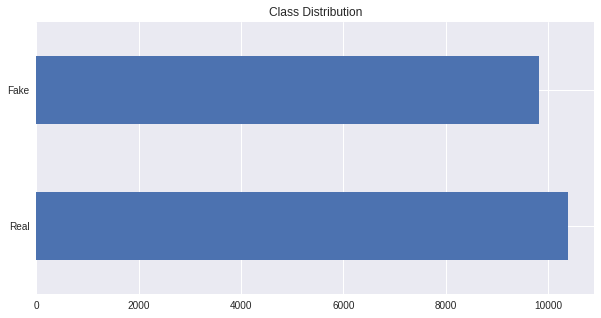

In [66]:
plt.figure(figsize=(10,5))
train['label'].value_counts().plot(kind='barh')
plt.yticks([1,0],['Fake','Real'])
plt.title('Class Distribution')
plt.show()

# **4. Data Preparation**

## **4.1. One-Hot Encoding text**

Tensorflow provides 2 options, when it comes to encode text to integers:

- [tf.keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)<br>
  eg:
  ```
  word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)
  ```
- [tf.keras.preprocessing.text.one_hot](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/one_hot)

One-hot encodes a text into a list of word indexes of size `voc_size`. This function receives as input a string of text and returns a list of encoded integers each corresponding to a word (or token) in the given input string. [[read more]](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/one_hot)

In [67]:
voc_size = 5000

X = train['title_lem'].values
y = train['label'].values

In [68]:
X[:2]

array(['house dem aide even see comey letter jason chaffetz tweeted',
       'flynn hillary clinton big woman campus breitbart'], dtype=object)

In [69]:
# One hot encoding sentences
X_encoded = [one_hot(words,voc_size)for words in X] 

In [70]:
X_encoded[:2]

[[3775, 804, 1199, 800, 2486, 498, 4415, 2103, 1287, 3253],
 [661, 1603, 3092, 3907, 1159, 568, 352]]

## **4.2. Padding encoded sequences**

Pads sequences to the same length. [[read more]](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

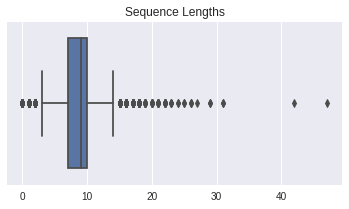

In [71]:
# checking length of sentence
lengths = [len(seq) for seq in X_encoded]
plt.figure(figsize=(6,3))
sns.boxplot(lengths)
plt.title("Sequence Lengths")
plt.show()

In [72]:
# Longest sequence
max_sent = max(lengths)
X_encoded = pad_sequences(X_encoded, padding='pre', maxlen=max_sent)
print(X_encoded[:2])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 3775  804 1199  800 2486
   498 4415 2103 1287 3253]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  661 1603
  3092 3907 1159  568  352]]


## **4.3. Word embeddings**

To use word embeddings, you can go for either of the following models:
1. word2vec model: 
  - https://code.google.com/archive/p/word2vec/
  - https://www.tensorflow.org/tutorials/text/word2vec
  - https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1
2. GloVe model : 
  - https://nlp.stanford.edu/projects/glove/
  - https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010

# **5. Model building and training**

In [73]:
## Creating model
voc_size = 5000
embedding_vector_features=40


model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 47, 40)            200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33, random_state=42)

In [75]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
212/212 [==============================] - 19s 81ms/step - loss: 0.4757 - accuracy: 0.7585 - val_loss: 0.1916 - val_accuracy: 0.9223
Epoch 2/10
212/212 [==============================] - 17s 78ms/step - loss: 0.1328 - accuracy: 0.9489 - val_loss: 0.1868 - val_accuracy: 0.9270
Epoch 3/10
212/212 [==============================] - 17s 78ms/step - loss: 0.0864 - accuracy: 0.9722 - val_loss: 0.2099 - val_accuracy: 0.9285
Epoch 4/10
212/212 [==============================] - 17s 78ms/step - loss: 0.0447 - accuracy: 0.9871 - val_loss: 0.2493 - val_accuracy: 0.9225
Epoch 5/10
212/212 [==============================] - 16s 78ms/step - loss: 0.0243 - accuracy: 0.9935 - val_loss: 0.3008 - val_accuracy: 0.9199
Epoch 6/10
212/212 [==============================] - 16s 78ms/step - loss: 0.0147 - accuracy: 0.9967 - val_loss: 0.4068 - val_accuracy: 0.9096
Epoch 7/10
212/212 [==============================] - 16s 78ms/step - loss: 0.0068 - accuracy: 0.9987 - val_loss: 0.4545 - val_accuracy:

In [76]:
'''from tensorflow.keras.layers import Dropout
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])'''

"from tensorflow.keras.layers import Dropout\n## Creating model\nembedding_vector_features=40\nmodel=Sequential()\nmodel.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))\nmodel.add(Dropout(0.3))\nmodel.add(LSTM(100))\nmodel.add(Dropout(0.3))\nmodel.add(Dense(1,activation='sigmoid'))\nmodel.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])"

In [77]:
y_pred = model.predict_classes(X_test)

In [78]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[3130,  290],
       [ 311, 2936]])

In [79]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9098545072746362